**Preparation**  
Import modules and load word lists

In [3]:
import os
from loguru import logger

from reliability_metrics import ReliabilityEstimator
import data_loader as dl
import paths
import utils
import numpy as np


TARGET_WORD_LISTS = {
    'nips_16_professions': dl.load_nips16_professions(),
    'pnas_18_professions': dl.load_pnas18_professions(),
    'pnas_18_adjectives': dl.load_pnas18_adjectives(),
    'google_10k': dl.load_google_10k(),
}
QUERIES = dl.load_weat_gender_related_concepts()
QUERIES['google_10k'] = TARGET_WORD_LISTS['google_10k']  
CORPORA = ['wikitext', 'reddit_ask_science', 'reddit_ask_historians']
ALGORITHMS = ['sgns', 'glove']
BIAS_MEASURES = ['db_wa', 'ripa', 'nbm']

In [13]:
# Use gender base pairs or sexual orientation base pairs
# choose bps type options: ['gender', 'sexual_orientation']
bp_options = ['gender', 'sexual_orientation']

bp_type = bp_options[1]    # use 0 for gender and 1 for sexual orientation base pairs

if bp_type == 'gender':
    bp_prefix = ''
elif bp_type == 'sexual_orientation':
    bp_prefix = 'so_'
else:
    print('Choose between types: gender or sexual_orientation')

print('Current base pair type is:', bp_type)

Current base pair type is: sexual_orientation


**Calculate Reliability**  

In [14]:
def estimate_reliability(bias_scores, bias_measures, target_words, 
                         gender_base_pairs, target_word_lists): 
    
    estimator = ReliabilityEstimator(
        bias_scores, bias_measures, target_words, gender_base_pairs)

    logger.info('Calculating test-retest reliability.')
    logger.info('Target words.')
    target_word_test_retest_dict = estimator.test_retest_target_words()
    logger.info('Gender base pair on full vocabulary.')
    gender_base_pair_test_retest_dict = {'full': estimator.test_retest_gender_base_pairs()}
    for list_name in target_word_lists:
        logger.info(f'Gender base pairs on target word list {list_name}.')
        gender_base_pair_test_retest_dict[list_name] = estimator.test_retest_gender_base_pairs(
                selected_target_words=target_word_lists[list_name])

    logger.info('Calculating inter-rater consistency.')
    logger.info('Target words.')
    target_words_inter_rater_dict = estimator.inter_rater_consistency_target_words()
    logger.info('Gender base pair on full vocabulary.')
    gender_base_pairs_inter_rater_dict = {
        'full': estimator.inter_rater_consistency_gender_base_pairs()}
    for list_name in target_word_lists:
        logger.info(f'Gender base pairs on target word list {list_name}.')
        gender_base_pairs_inter_rater_dict[list_name] = \
            estimator.inter_rater_consistency_gender_base_pairs(
                selected_target_words=target_word_lists[list_name])

    logger.info('Calculating internal consistency.')
    internal_consistency_dict = {}
    for query_name in QUERIES:
        internal_consistency_dict[query_name] = estimator.internal_consistency(
            selected_target_words=QUERIES[query_name])

    return target_word_test_retest_dict, gender_base_pair_test_retest_dict, \
               target_words_inter_rater_dict, gender_base_pairs_inter_rater_dict, internal_consistency_dict


reliability_dicts = {corpus: {} for corpus in CORPORA}
bias_scores_dict = {alg: [] for alg in ALGORITHMS}

for corpus in CORPORA:
    logger.info(f'Processing {corpus}.')
    # Load words
    vocab_path, _, _= dl.get_embed_paths_from_folder(paths.embed_folders[corpus])
    vocab = dl.load_vocab(vocab_path)
    vocab.discard('<unk>')
    vocab.discard('<raw_unk>')
    target_word_lists = {list_name: [word for word in TARGET_WORD_LISTS[list_name] if word in vocab] 
                         for list_name in TARGET_WORD_LISTS}
# Estimate reliability
    for algorithm in ALGORITHMS:
        logger.info(f'processing {algorithm}')
        reliability_dict_path = os.path.join(paths.reliability_dict_dirs[corpus], f'{bp_prefix + algorithm}.pkl')
        bias_path = os.path.join(paths.bias_scores_folders[corpus], f'{bp_prefix + algorithm}.pkl')
        [bias_measures, target_words, base_pairs, _], bias_scores = utils.load_pickle(bias_path)
        # store results for calculating pearson's r
        # average over the number of n_embeds and n_pairs
        avged_scores = bias_scores.mean(axis=3).mean(axis=2)  # n_bias_metrics, n_target_words
        bias_scores_dict[algorithm].append(avged_scores)

        if not os.path.isfile(reliability_dict_path):
            print('Calculation reliability scores...')
            target_word_test_retest_dict, base_pair_test_retest_dict, \
                target_words_inter_rater_dict, base_pairs_inter_rater_dict,\
                internal_consistency_dict = estimate_reliability(
                    bias_scores, bias_measures, target_words, base_pairs, target_word_lists)

            reliability_dict = {
                'test-retest': [target_word_test_retest_dict, base_pair_test_retest_dict],
                'inter-rater': [target_words_inter_rater_dict, base_pairs_inter_rater_dict],
                'internal': internal_consistency_dict
            }
            utils.write_pickle(reliability_dict, reliability_dict_path)
            reliability_dicts[corpus][algorithm] = reliability_dict
        else:
            # load dict
            print('Loading reliability scores...')
            reliability_dict = utils.load_pickle(reliability_dict_path)
            reliability_dicts[corpus][algorithm] = reliability_dict

2022-02-03 16:30:42.342 | INFO     | __main__:<module>:43 - Processing wikitext.
2022-02-03 16:30:42.464 | INFO     | __main__:<module>:53 - processing sgns


Loading reliability scores...


2022-02-03 16:30:44.062 | INFO     | __main__:<module>:53 - processing glove


Loading reliability scores...


2022-02-03 16:30:45.802 | INFO     | __main__:<module>:43 - Processing reddit_ask_science.
2022-02-03 16:30:45.840 | INFO     | __main__:<module>:53 - processing sgns
2022-02-03 16:30:46.239 | INFO     | __main__:<module>:53 - processing glove


Loading reliability scores...


2022-02-03 16:30:46.556 | INFO     | __main__:<module>:43 - Processing reddit_ask_historians.
2022-02-03 16:30:46.601 | INFO     | __main__:<module>:53 - processing sgns


Loading reliability scores...


2022-02-03 16:30:47.049 | INFO     | __main__:<module>:53 - processing glove


Loading reliability scores...
Loading reliability scores...


**Prepare Visualization**  
Import modules, decide the abbreviations of names (too long for the figures), and load data.

In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import utils

plt.rcParams.update({"text.usetex": False})

ALGORITHM_NAMES = {
    'sgns': 'SGNS',
    'glove': 'GloVe'
}
BIAS_MEASURE_ABBREVIATIONS = {
    'db_wa': 'DB/WA',
    'ripa': 'RIPA',
    'nbm': 'NBM'
}
TARGET_WORD_LIST_ABBREVIATIONS = {
    'full': 'Full',
    'full_vocab': 'Full',
    'google_10k': 'Google10K',
    'nips_16_professions': 'OCC16',
    'pnas_18_professions': 'OCC18',
    'pnas_18_adjectives': 'ADJ'
}
CORPUS_ABBREVIATIONS = {
    'wikitext': 'WikiText-103',
    'reddit_ask_science': 'r/AskScience',
    'reddit_ask_historians': 'r/AskHistorians'
}
QUERY_NAME_ABBREVIATIONS = {
    'career': 'career',
    'family': 'family',
    'arts': 'arts',
    'arts_2': 'arts_2',
    'math': 'math',
    'science': 'science',
    'base pairs': 'base pairs'
}

if bp_type == 'gender':
    BASE_PAIRS = list(reliability_dicts[CORPORA[0]][ALGORITHMS[0]]
                    ['test-retest'][1][list(TARGET_WORD_LISTS)[0]][BIAS_MEASURES[0]])
elif bp_type == 'sexual_orientation':
    BASE_PAIRS = list(reliability_dicts[CORPORA[1]][ALGORITHMS[0]]
                    ['test-retest'][1][list(TARGET_WORD_LISTS)[0]][BIAS_MEASURES[0]])

**Visualization: Test-retest Reliability**  

sgns@wikitext
sexual_orientation base pairs


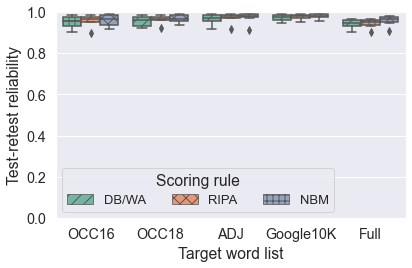

Target words


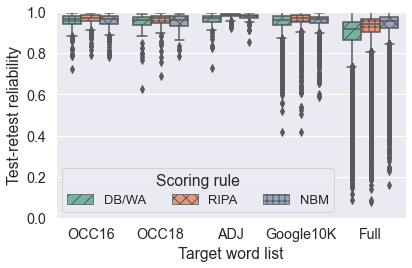

glove@wikitext
sexual_orientation base pairs


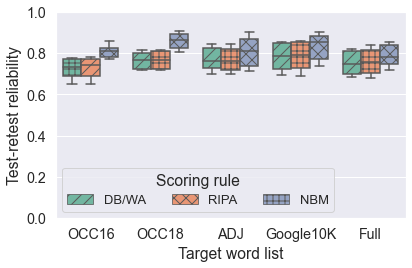

Target words


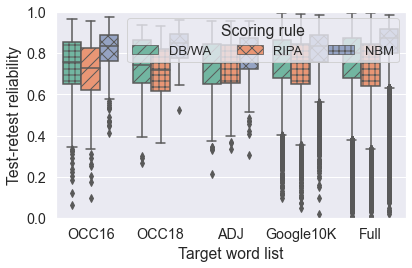

sgns@reddit_ask_science
sexual_orientation base pairs


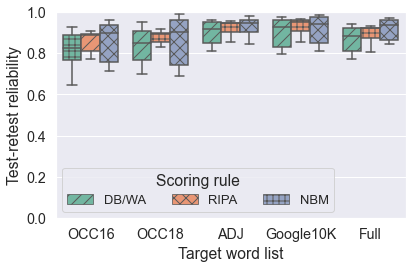

Target words


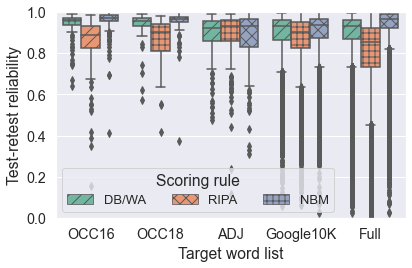

glove@reddit_ask_science
sexual_orientation base pairs


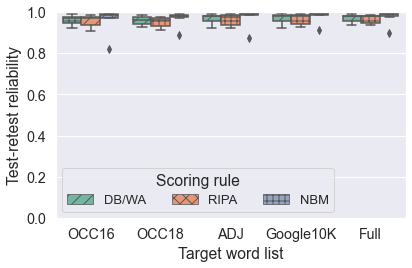

Target words


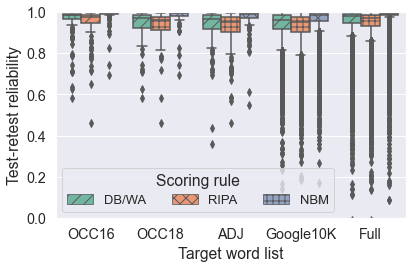

sgns@reddit_ask_historians
sexual_orientation base pairs


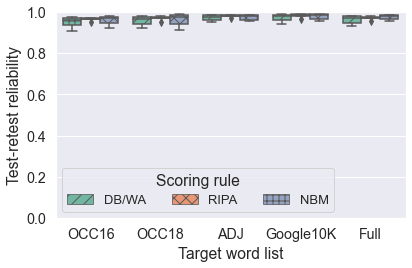

Target words


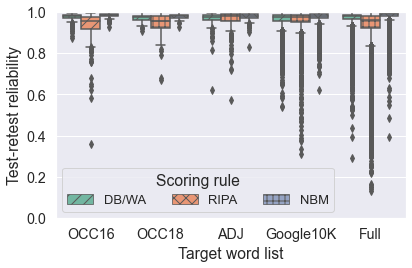

glove@reddit_ask_historians
sexual_orientation base pairs


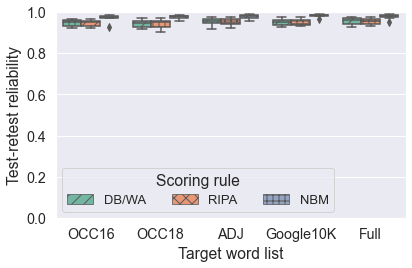

Target words


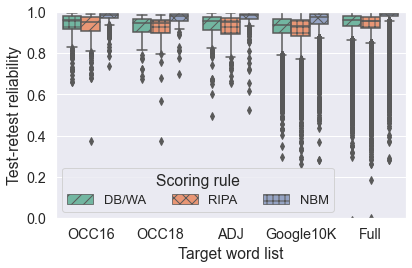

In [16]:
from itertools import cycle

# target word list for estimating the test-retest reliability 
test_retest_word_list = ['nips_16_professions', 'pnas_18_professions', 
                         'pnas_18_adjectives', 'google_10k', 'full']

corpus_vocabs = {}
sns.set(font_scale=1.3)
sns.set_palette('Set2')

hatches = cycle(["//", "++", "xx"])

for corpus in CORPORA:
    for algorithm in ALGORITHMS:
        print(f'{algorithm}@{corpus}')
        target_word_test_retest_dict, base_pair_test_retest_dict = \
        reliability_dicts[corpus][algorithm]['test-retest']
        
        # test-retest reliability
        print('{} base pairs'.format(bp_type))
        df = pd.DataFrame([{'Target word list': TARGET_WORD_LIST_ABBREVIATIONS[list_name], 
                            'Scoring rule': BIAS_MEASURE_ABBREVIATIONS[bias_measure], 'bp': base_pair, 
                            'Test-retest reliability': base_pair_test_retest_dict[list_name][bias_measure][base_pair]} 
                           for list_name in test_retest_word_list for bias_measure in BIAS_MEASURES 
                           for base_pair in BASE_PAIRS]) 
        ax = sns.boxplot(x='Target word list', y='Test-retest reliability', hue='Scoring rule', data=df)
        # legend hatch
        for i, patch in enumerate(ax.patches):
            hatch = next(hatches)
            patch.set_hatch(hatch)
        ax.legend(ncol=3, title='Scoring rule', fontsize='small')
        # box hatch
        for i, patch in enumerate(ax.artists):
            hatch = next(hatches)
            patch.set_hatch(hatch)
        plt.ylim((0, 1))
        plt.tight_layout()
        plt.savefig(os.path.join(paths.gbps_test_retest_image_dir, bp_prefix + corpus + '_bps_' + algorithm))
        plt.show()
        plt.close()
        
        print('Target words')
        if corpus in corpus_vocabs:
            corpus_vocab = corpus_vocabs[corpus]
        else:
            corpus_vocab = {list_name: [word for word in TARGET_WORD_LISTS[list_name] if word in target_word_test_retest_dict[BIAS_MEASURES[0]]] 
                                for list_name in TARGET_WORD_LISTS}
            corpus_vocab['full'] = [word for word in target_word_test_retest_dict[BIAS_MEASURES[0]]]
            corpus_vocabs[corpus] = corpus_vocab

        df = pd.DataFrame([{
            'Test-retest reliability': target_word_test_retest_dict[bias_measure][word],
            'Scoring rule': BIAS_MEASURE_ABBREVIATIONS[bias_measure],
            'word': word, 'Target word list': TARGET_WORD_LIST_ABBREVIATIONS[list_name]}
            for list_name in corpus_vocab for word in corpus_vocab[list_name]
            for bias_measure in BIAS_MEASURES])

        ax = sns.boxplot(x='Target word list', y='Test-retest reliability', hue='Scoring rule', data=df)
        # legend hatch
        for i, patch in enumerate(ax.patches):
            hatch = next(hatches)
            patch.set_hatch(hatch)
        ax.legend(ncol=3, title='Scoring rule', fontsize='small')
        # box hatch
        for i, patch in enumerate(ax.artists):
            hatch = next(hatches)
            patch.set_hatch(hatch)

        plt.ylim((0, 1))
        plt.tight_layout()
        plt.savefig(os.path.join(paths.target_words_test_retest_image_dir, bp_prefix + corpus + '_targetwords_' + algorithm))
        plt.show()
        plt.close()

**Visualization: Inter-rater Consistency** 

sgns
sexual_orientation base pairs


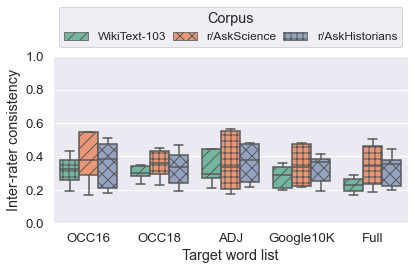

Target Words


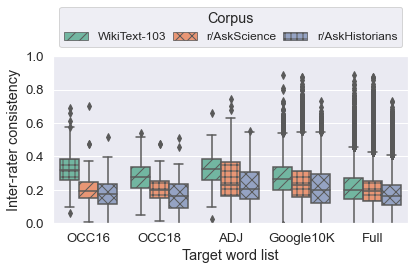

glove
sexual_orientation base pairs


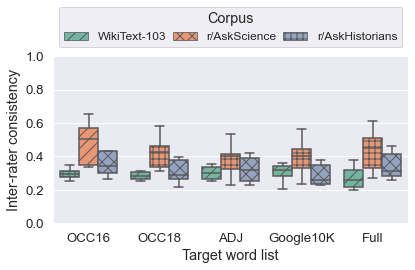

Target Words


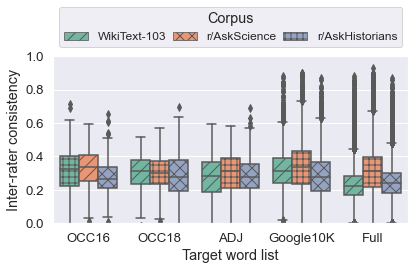

In [17]:
sns.set(font_scale=1.2)
sns.set_palette('Set2')

inter_rater_word_lists = ['nips_16_professions', 'pnas_18_professions', 'pnas_18_adjectives', 'google_10k', 'full']

# inter-rater consistency reliability
for algorithm in ALGORITHMS:
    print(algorithm)
    # base pairs
    print('{} base pairs'.format(bp_type))
    df = pd.DataFrame([{
        'Target word list': TARGET_WORD_LIST_ABBREVIATIONS[list_name], 'bp': base_pair,
        'Inter-rater consistency': reliability_dicts[corpus][algorithm]['inter-rater'][1][list_name][base_pair],
        'Corpus': CORPUS_ABBREVIATIONS[corpus], 'Bias measure': bias_measure} for list_name in inter_rater_word_lists for bias_measure in BIAS_MEASURES
        for base_pair in BASE_PAIRS for corpus in CORPORA])
    ax = sns.boxplot(x='Target word list', y='Inter-rater consistency', hue='Corpus', data=df)
    # legend hatch
    for i, patch in enumerate(ax.patches):
        hatch = next(hatches)
        patch.set_hatch(hatch)

    ax.legend(ncol=3, title='Corpus', fontsize='small', mode='expand', 
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3)
    # box hatch
    for i, patch in enumerate(ax.artists):
        hatch = next(hatches)
        patch.set_hatch(hatch)
    plt.ylim((0, 1))
    plt.tight_layout()
    plt.savefig(os.path.join(paths.gbps_inter_rater_image_dir, bp_prefix + 'bps_' + algorithm))
    plt.show()
    plt.close()
    
    print('Target Words')
    df = pd.DataFrame([{
        'Target word list': TARGET_WORD_LIST_ABBREVIATIONS[list_name], 'word': word,
        'Inter-rater consistency': reliability_dicts[corpus][algorithm]['inter-rater'][0][word],
        'Corpus': CORPUS_ABBREVIATIONS[corpus]}
        for corpus in corpus_vocabs
        for list_name in corpus_vocabs[corpus]
        for word in corpus_vocabs[corpus][list_name]])
    ax = sns.boxplot(x='Target word list', y='Inter-rater consistency', hue='Corpus', data=df)
    # legend hatch
    for i, patch in enumerate(ax.patches):
        hatch = next(hatches)
        patch.set_hatch(hatch)

    ax.legend(ncol=3, title='Corpus', fontsize='small', mode='expand', 
              bbox_to_anchor=(0., 1.02, 1., .102), loc=3)
    # box hatch
    for i, patch in enumerate(ax.artists):
        hatch = next(hatches)
        patch.set_hatch(hatch)
    plt.ylim((0, 1))
    plt.tight_layout()
    plt.savefig(os.path.join(paths.target_words_inter_rater_image_dir, bp_prefix + 'targetwords_' + algorithm))
    plt.show()
    plt.close()

In [18]:
from scipy import stats

# first combine the bias scores for all corpora and then calculate Pearson's r
for algorithm in ALGORITHMS:
    corpus_scores = []
    all_bias_scores = np.hstack(([corp_score for corp_score in bias_scores_dict[algorithm]]))
    db_wa = all_bias_scores[0, :]
    ripa = all_bias_scores[1, :]
    nbm = all_bias_scores[2, :]
    print(algorithm)
    print('ripa/nbm', stats.pearsonr(ripa, nbm))
    print('db_wa/ripa', stats.pearsonr(db_wa, ripa))
    print('db_wa/nbm', stats.pearsonr(db_wa, nbm))

sgns
ripa/nbm (0.7229267058361846, 0.0)
db_wa/ripa (0.8841555273197467, 0.0)
db_wa/nbm (0.6537985022548145, 0.0)
glove
ripa/nbm (0.7626777938850504, 0.0)
db_wa/ripa (0.9864860818112713, 0.0)
db_wa/nbm (0.7480027492532622, 0.0)


**Visualization: Internal Consistency**

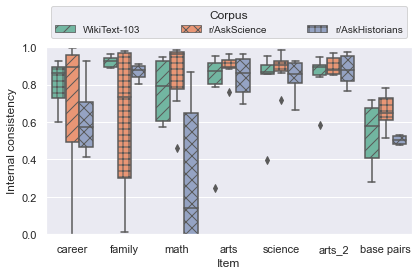

In [19]:
sns.set(font_scale=1.0)
sns.set_palette('Set2')

df_data = []
for corpus in CORPORA:
    for algorithm in ALGORITHMS:
        internal_dict = reliability_dicts[corpus][algorithm]['internal']
        query_names = list(internal_dict)
        for query_name in query_names:
            # gbp
            if query_name == 'google_10k':
                value_dict = internal_dict[query_name]['base pairs']
                df_key = 'base pairs'
            else:
                value_dict = internal_dict[query_name]['target words']
                df_key = query_name
            for bias_measure in BIAS_MEASURES:
                df_data.append({'corpus': CORPUS_ABBREVIATIONS[corpus],
                                'algorithm': algorithm,
                                'Scoring rule': BIAS_MEASURE_ABBREVIATIONS[bias_measure],
                                'Item': QUERY_NAME_ABBREVIATIONS[df_key],
                                'Internal consistency': value_dict[bias_measure]})
df_data = pd.DataFrame(df_data)
ax = sns.boxplot(x='Item', y='Internal consistency', hue='corpus', data=df_data)
# legend hatch
for i, patch in enumerate(ax.patches):
    hatch = next(hatches)
    patch.set_hatch(hatch)
ax.legend(ncol=3, title='Corpus', fontsize='small', mode='expand',
          bbox_to_anchor=(0., 1.02, 1., .102), loc=3)
# box hatch
for i, patch in enumerate(ax.artists):
    hatch = next(hatches)
    patch.set_hatch(hatch)
plt.ylim((0, 1))
plt.tight_layout()
plt.savefig(os.path.join(paths.internal_image_dir, bp_prefix + 'internal_consistency'))
plt.show()
plt.close()

**Factors Influencing the Reliability of Base Pairs**


Test-retest reliability


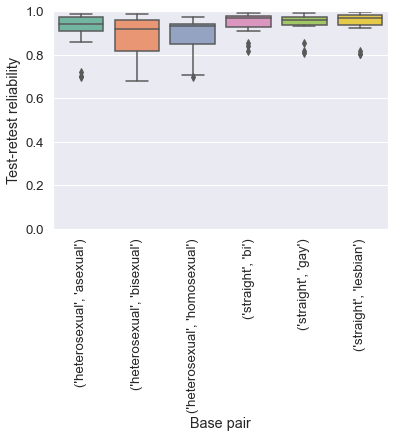

Inter-rater consistency


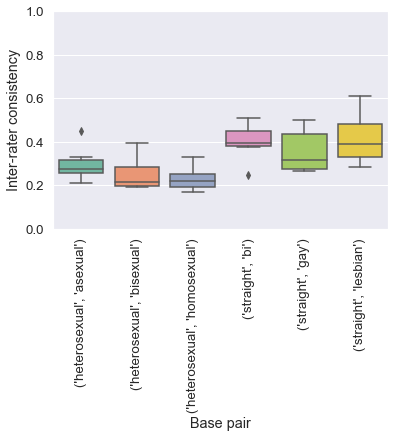

In [29]:
# create image folder 
loc = os.path.join(paths.reliability_images_dir + 'reliability_gbps')
if not os.path.exists(loc):
    os.makedirs(loc)
    print('Created directory', loc)

BASE_PAIRS = sorted(BASE_PAIRS)
x_axis_vals = list(range(len(BASE_PAIRS)))
sns.set(font_scale=1.2)
sns.set_palette('Set2')

print('Test-retest reliability')
test_retest_base_pair_dist = []
for corpus in CORPORA:
    for algorithm in ALGORITHMS:
        for bias_measure in BIAS_MEASURES:
            for base_pair_idx, base_pair in enumerate(BASE_PAIRS):
                test_retest_base_pair_dist.append({
                    'Test-retest reliability': reliability_dicts[corpus][algorithm]
                    ['test-retest'][1]['full'][bias_measure][base_pair],
                    'Base pair': base_pair_idx})

sns.boxplot(data=pd.DataFrame(test_retest_base_pair_dist), x='Base pair', y='Test-retest reliability')
plt.xticks(x_axis_vals, BASE_PAIRS, rotation='vertical')
plt.ylim((0, 1))
if bp_type == 'gender':
    plt.tight_layout()
    plt.savefig(os.path.join(loc, bp_prefix + 'bps_test_retest'))
else:
    plt.savefig(os.path.join(loc, bp_prefix + 'bps_test_retest'), bbox_inches='tight')
plt.show()
plt.close()

print('Inter-rater consistency')
inter_rater_base_pair_dist = []
for corpus in CORPORA:
    for algorithm in ALGORITHMS:
        for base_pair_idx, base_pair in enumerate(BASE_PAIRS):
            inter_rater_base_pair_dist.append({
                'Inter-rater consistency': reliability_dicts[corpus][algorithm]
                ['inter-rater'][1]['full'][base_pair],
                'Base pair': base_pair_idx})
sns.boxplot(data=pd.DataFrame(inter_rater_base_pair_dist), x='Base pair', y='Inter-rater consistency')
plt.xticks(x_axis_vals, BASE_PAIRS, rotation='vertical')
plt.ylim((0, 1))
if bp_type == 'gender':
    plt.tight_layout()
    plt.savefig(os.path.join(loc, bp_prefix + 'bps_inter_rater'))
else:
    plt.savefig(os.path.join(loc, bp_prefix + 'bps_inter_rater'), bbox_inches='tight')
plt.show()
plt.close()
